Objective of this jupyter notebook is to explore how to create a heat map of the player movement in a round. What would result out of it is a good idea of the map control the Gentle Mates acquires and at what time.

- How : Object Detection in the map 
    -> Gather Data of a map
    -> Label the data
    -> train model with roboflow


In [ ]:
!pip install roboflow

In [6]:
from roboflow import Roboflow

def load_model():
    rf = Roboflow(api_key="xEb6a3dXc9T0RuJ5Qnox")
    project = rf.workspace().project("valorant-heat-map")
    model = project.version(2).model
    return model

model = load_model()

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
# infer on a local image
model.predict("heatmaps_data/round3_lotus.mp4", confidence=40, overlap=30).save("prediction.mp4")

In [1]:
!pip install opencv-python

  Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl (38.6 MB)


In [2]:
import cv2
import os

def extract_frames(video_path, output_folder):
    # Open the video file
    video_capture = cv2.VideoCapture(video_path)

    # Get the frames per second (fps) of the input video
    fps = video_capture.get(cv2.CAP_PROP_FPS)

    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Initialize variables
    frame_list = []
    success, frame = video_capture.read()
    count = 0

    # Loop through the video and extract frames
    while success:
        # Save the frame to the output folder
        frame_filename = os.path.join(output_folder, f"frame_{count}.png")
        cv2.imwrite(frame_filename, frame)

        # Add the frame to the list
        frame_list.append(frame_filename)

        # Move to the next second in the video
        video_capture.set(cv2.CAP_PROP_POS_FRAMES, int(count * fps))

        # Read the next frame
        success, frame = video_capture.read()

        # Increment the count
        count += 1

    # Release the video capture object
    video_capture.release()

    return frame_list

In [ ]:
video_path = "heatmaps_data/round3_lotus.mp4"
output_folder = "heatmaps_data/round3_lotus_images/"

extract_frames(video_path, output_folder)

In [4]:
def get_file_names_in_folder(folder_path):
    """
    Get a list of all file names in a folder.
    
    Parameters:
    - folder_path (str): The path to the folder.

    Returns:
    - List[str]: A list of file names in the folder.
    """
    file_names = []
    for filename in os.listdir(folder_path):
        if os.path.isfile(os.path.join(folder_path, filename)):
            file_names.append(filename)
    return file_names

def evaluation(model, paths_to_images):
    
    report = []
    for i,image in enumerate(paths_to_images):
        print(f'{i} ---> {len(paths_to_images)}')
        report.append(model.predict("heatmaps_data/round3_lotus_images/" + image, confidence=40, overlap=30).json())
    
    return report

In [ ]:
import os

report = evaluation(model, get_file_names_in_folder("heatmaps_data/round3_lotus_images/"))

In [ ]:
report

In [64]:
def process_data(report):
    coordinates = []
    for i, element in enumerate(report):
        for j in range(len(element['predictions'])):
            coordinate = {'x': 0, 'y': 0, 'class': None, 'time': 0}
            coordinate['x'] += element['predictions'][j]['x']
            coordinate['y'] += element['predictions'][j]['y']
            coordinate['class'] = element['predictions'][j]['class']
            coordinate['time'] += i
            coordinates.append(coordinate)
    return coordinates

In [ ]:
report[19]['predictions']

In [ ]:
!pip install matplotlib
!pip install cv2
!pip install numpy
!pip install PIL

In [ ]:
report[0].get('predictions', [])

In [54]:
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json

def show_heatmaps_from_report(report):
    
    for item in report:
        predictions = item.get('predictions', [])

        for prediction in predictions:
            class_name = prediction['class']
            if class_name not in ['DFS', 'ATK']:
                continue  # Skip classes other than 'DFS' and 'ATK'

            image_path = prediction['image_path']
            image = cv2.imread(image_path)

            # Create a figure and axes
            fig, ax = plt.subplots(1)
            ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

            # Extract bounding box coordinates
            x, y, width, height = prediction['x'], prediction['y'], prediction['width'], prediction['height']

            # Create a rectangle patch
            rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')

            # Add the rectangle to the Axes
            ax.add_patch(rect)

            # Display class and confidence
            ax.text(x, y - 5, f'{class_name} - {prediction["confidence"]:.2f}', color='r')

            # Show the plot
            plt.show()

In [ ]:
show_heatmaps_from_report(report, "")

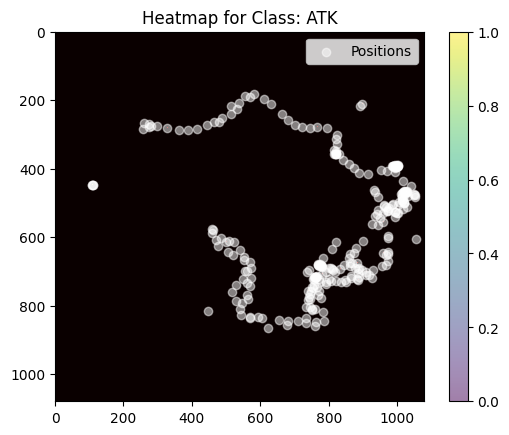

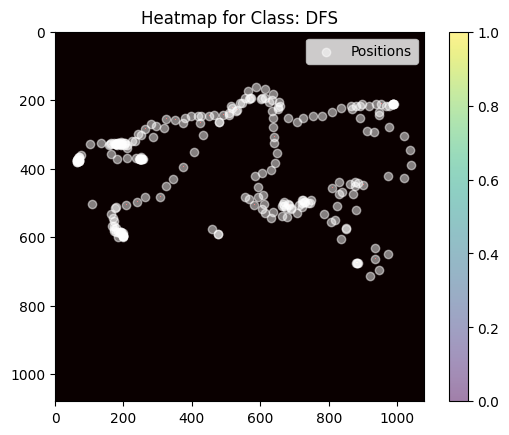

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def create_heatmap(coordinates):
    # Extract unique classes
    unique_classes = set(coord['class'] for coord in coordinates)

    # Initialize a dictionary to store counts for each class
    class_counts = {cls: np.zeros((1080, 1080)) for cls in unique_classes}

    # Loop through coordinates and accumulate counts
    for coord in coordinates:
        x, y, cls = coord['x'], coord['y'], coord['class']
        class_counts[cls][y, x] += 1  # Note the reversed y, x for image coordinates

    # Plot heatmaps for each class
    for cls, counts in class_counts.items():
        plt.imshow(counts, cmap='hot', interpolation='nearest', origin='upper')

        # Scatter plot with increased alpha for better visibility
        plt.scatter([], [], c='w', marker='o', label='Positions', alpha=0.5)

        plt.title(f'Heatmap for Class: {cls}')
        plt.colorbar()

        # Show scatter plot of positions
        positions_x, positions_y = np.where(class_counts[cls] > 0)
        plt.scatter(positions_y, positions_x, c='w', marker='o', alpha=0.5)

        plt.legend()
        plt.show()

# Example usage:
data = process_data(report)


create_heatmap(data)

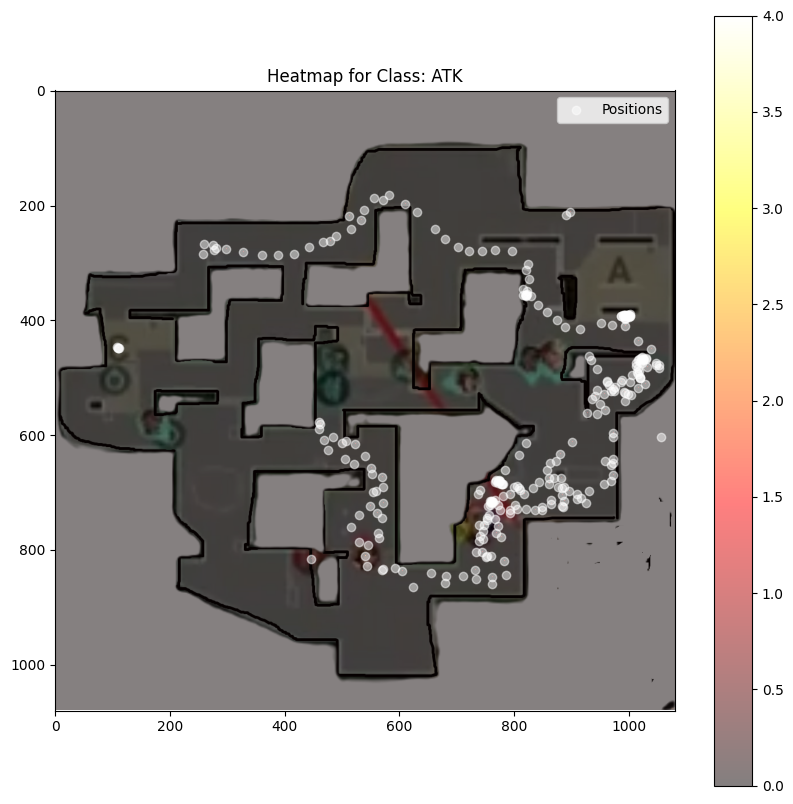

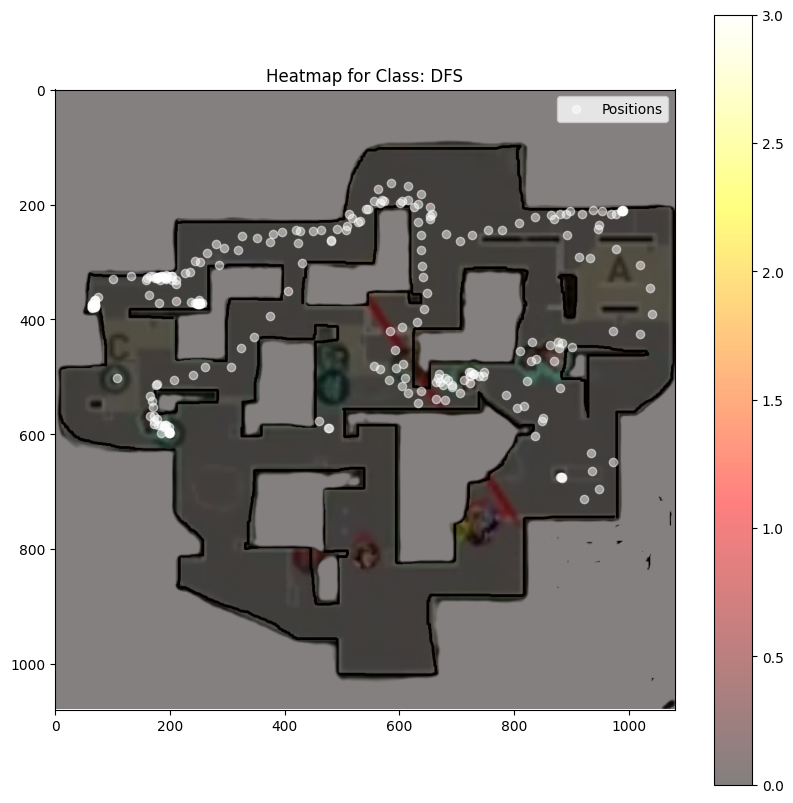

In [69]:
import numpy as np
import matplotlib.pyplot as plt

def create_heatmap_with_background(coordinates, image_path):
    # Extract unique classes
    unique_classes = set(coord['class'] for coord in coordinates)

    # Initialize a dictionary to store counts for each class
    class_counts = {cls: np.zeros((1080, 1080)) for cls in unique_classes}

    # Loop through coordinates and accumulate counts
    for coord in coordinates:
        x, y, cls = coord['x'], coord['y'], coord['class']
        class_counts[cls][y, x] += 1  # Note the reversed y, x for image coordinates

    # Load the image as the background
    background_image = plt.imread(image_path)

    # Plot heatmaps for each class on top of the image
    for cls, counts in class_counts.items():
        fig, ax = plt.subplots(figsize=(10, 10))

        # Display the image as the background
        ax.imshow(background_image, extent=[0, 1080, 1080, 0])

        # Plot the heatmap
        im = ax.imshow(counts, cmap='hot', interpolation='nearest', origin='upper', alpha=0.5)

        plt.title(f'Heatmap for Class: {cls}')
        plt.colorbar(im)

        # Show scatter plot of positions
        positions_x, positions_y = np.where(class_counts[cls] > 0)
        ax.scatter(positions_y, positions_x, c='w', marker='o', alpha=0.5, label='Positions')

        plt.legend()
        plt.show()

image_path = "heatmaps_data/test_heatmap.png"  # Replace with the actual path to your image
create_heatmap_with_background(data, image_path)

In [66]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample data (replace this with your actual data)

# Set up the white board
board_size = 1080
white_board = np.zeros((board_size, board_size))

# Iterate through each time unit
for time_unit in sorted(set(item['time'] for item in data)):
    # Filter data for the current time unit
    time_data = [item for item in data if item['time'] == time_unit]

    # Extract positions and classes for the current time unit
    positions = np.array([item['position'] for item in time_data])
    classes = np.array([item['class'] for item in time_data])

    # Scatter positions onto the white board
    white_board[positions[:, 1], positions[:, 0]] += 1  # Assuming (y, x) coordinates

# Create a heatmap using seaborn
plt.figure(figsize=(10, 10))
sns.heatmap(white_board, cmap='viridis', square=True, cbar_kws={'label': 'Frequency'})
plt.title('Position Heatmap')
plt.show()

KeyError: 'position'